Data shape: (4874, 6)

Basic statistics:
         Adj Close        Volume
count  4874.000000  4.874000e+03
mean    104.686524  1.681687e+07
std     155.940368  1.937625e+07
min       0.372857  2.856000e+05
25%       3.905714  6.301225e+06
50%      21.233572  1.084630e+07
75%     125.097502  2.016192e+07
max     610.340027  3.234140e+08

ARIMA ANALYSIS FOR NETFLIX STOCK DATA

Stationarity Test for Adj Close
ADF Statistic: 2.793546
p-value: 1.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Series is non-stationary (p > 0.05)

Stationarity Test for Volume
ADF Statistic: -4.758723
p-value: 0.000065
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Series is stationary (p < 0.05)

Adj Close becomes stationary after 1 differencing
ADF p-value: 0.000000

Volume becomes stationary after 1 differencing
ADF p-value: 0.000000

ARIMA Parameter Identification for Adj Close
Suggested AR(p) order based on PACF: 38
Suggested MA(q) order based on ACF: 40
Adjusted AR(p) order to prevent

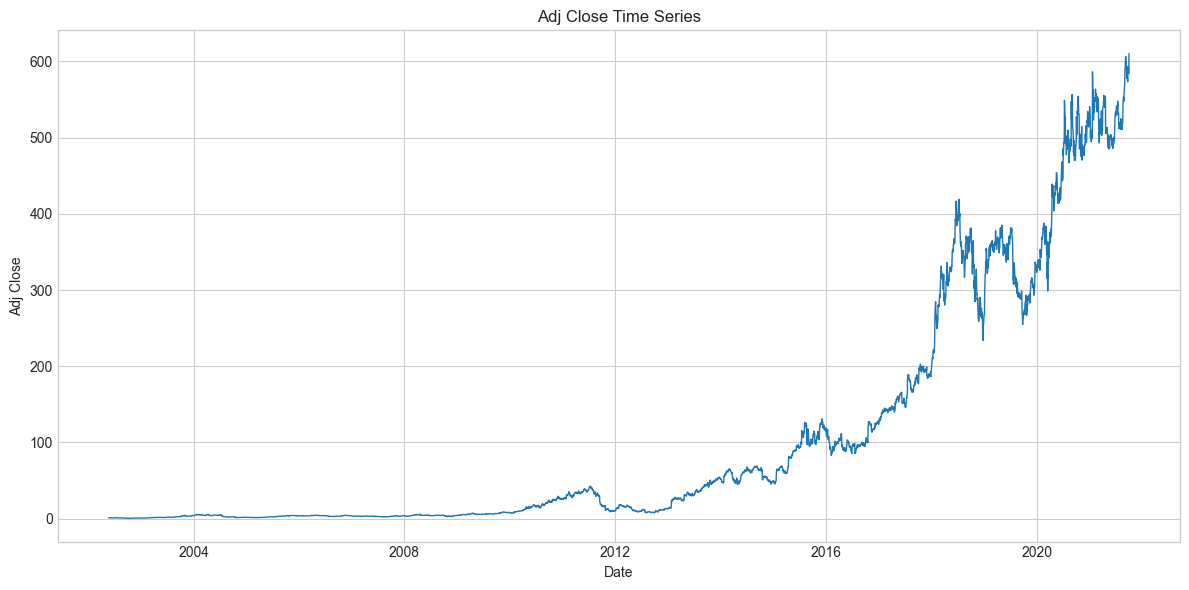

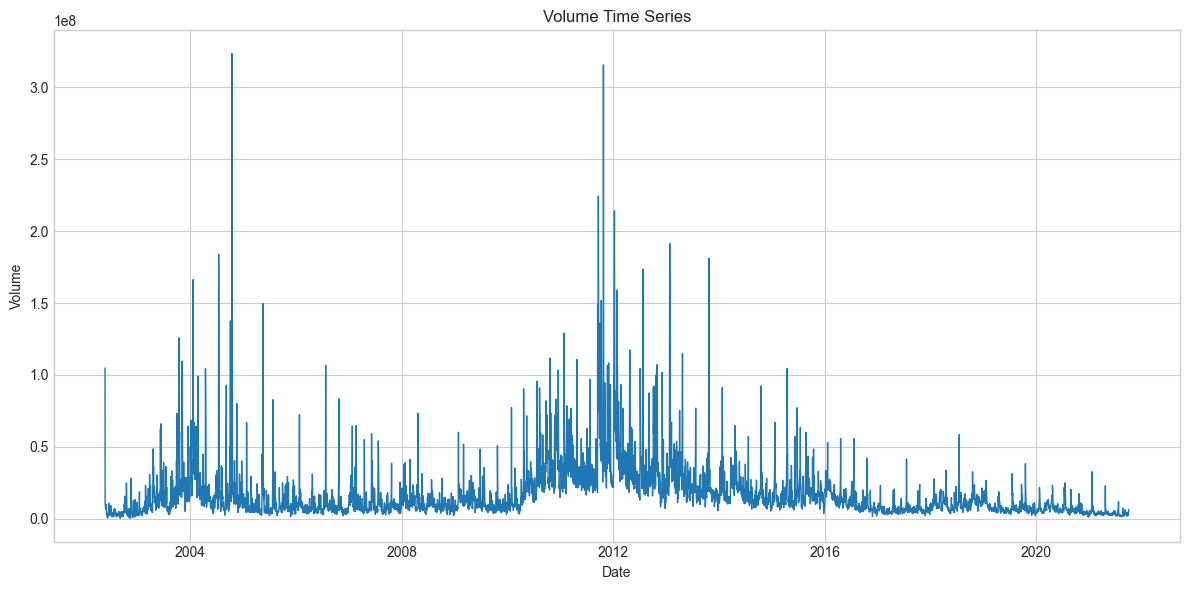

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('C:\\Users\\Aru\\Downloads\\archive\\NFLX.csv')

# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Display basic information
print("Data shape:", df.shape)
print("\nBasic statistics:")
print(df[['Adj Close', 'Volume']].describe())

#--------------------------------------
# ARIMA STATISTICAL TESTS
#--------------------------------------

# Test for stationarity using Augmented Dickey-Fuller test
def test_stationarity(time_series, title):
    print(f"\nStationarity Test for {title}")
    result = adfuller(time_series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] < 0.05:
        print(f"Series is stationary (p < 0.05)")
    else:
        print(f"Series is non-stationary (p > 0.05)")

# Apply differencing to achieve stationarity
def difference_series(time_series, title, max_diff=2):
    diff_series = time_series.copy()
    stationary = False
    diff_order = 0
    
    for d in range(1, max_diff+1):
        diff_series = diff_series.diff().dropna()
        
        result = adfuller(diff_series.dropna())
        is_stationary = result[1] < 0.05
        
        if is_stationary and not stationary:
            stationary = True
            diff_order = d
            print(f"\n{title} becomes stationary after {d} differencing")
            print(f"ADF p-value: {result[1]:.6f}")
            break
        
    if not stationary:
        print(f"\n{title} did not become stationary after {max_diff} differencing")
        diff_order = max_diff
    
    return diff_series, diff_order

# Identify ARIMA parameters
def identify_arima_orders(diff_series, title):
    # Calculate ACF and PACF values
    acf_vals = acf(diff_series, nlags=40)
    pacf_vals = pacf(diff_series, nlags=40)
    
    confidence_level = 1.96 / np.sqrt(len(diff_series))
    
    significant_acf = [i for i, val in enumerate(acf_vals) if abs(val) > confidence_level]
    q_candidate = max(significant_acf) if significant_acf else 0
    
    significant_pacf = [i for i, val in enumerate(pacf_vals) if abs(val) > confidence_level]
    p_candidate = max(significant_pacf) if significant_pacf else 0
    
    print(f"\nARIMA Parameter Identification for {title}")
    print(f"Suggested AR(p) order based on PACF: {p_candidate}")
    print(f"Suggested MA(q) order based on ACF: {q_candidate}")
    
    p_adjusted = min(p_candidate, 5)  # Limit p to avoid overfitting
    q_adjusted = min(q_candidate, 5)  # Limit q to avoid overfitting
    
    print(f"Adjusted AR(p) order to prevent overfitting: {p_adjusted}")
    print(f"Adjusted MA(q) order to prevent overfitting: {q_adjusted}")
    
    return p_adjusted, q_adjusted

# Fit ARIMA model and evaluate
def fit_arima_model(series, p, d, q, title):
    # Split data into train and test sets
    train_size = int(len(series) * 0.8)
    train, test = series[:train_size], series[train_size:]
    
    print(f"\nFitting ARIMA({p},{d},{q}) model for {title}")
    print(f"Training data points: {len(train)}")
    print(f"Testing data points: {len(test)}")
    
    try:
        # Fit the ARIMA model
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        
        # Print model summary statistics
        print("\nModel Summary Statistics:")
        print(model_fit.summary().tables[1].as_text())
        
        # Forecast for test period
        forecast = model_fit.forecast(steps=len(test))
        
        # Calculate error metrics
        mse = mean_squared_error(test, forecast)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test, forecast)
        
        print(f"\nTest Set Metrics:")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        
        # Test for white noise
        residuals = pd.Series(model_fit.resid, index=train.index)
        lb_test = sm.stats.acorr_ljungbox(residuals, lags=[10])
        print("\nLjung-Box Test for Residual Autocorrelation:")
        print(f"p-value: {lb_test.iloc[0, 1]:.6f}")
        
        if lb_test.iloc[0, 1] > 0.05:
            print("Residuals appear to be white noise (good model fit)")
        else:
            print("Residuals show autocorrelation (model may be inadequate)")
            
        return model_fit, forecast
        
    except Exception as e:
        print(f"Error fitting ARIMA model: {e}")
        return None, None

# Compare different ARIMA specifications
def compare_arima_specs(series, title, max_p=2, max_d=2, max_q=2):
    print(f"\nComparing ARIMA specifications for {title}")
    
    best_aic = float('inf')
    best_params = None
    best_model = None
    
    results = []
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                if p == 0 and d == 0 and q == 0:
                    continue
                    
                try:
                    model = ARIMA(series, order=(p, d, q))
                    model_fit = model.fit()
                    
                    aic = model_fit.aic
                    
                    results.append({
                        'p': p, 'd': d, 'q': q,
                        'AIC': aic
                    })
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_params = (p, d, q)
                        best_model = model_fit
                    
                    print(f"ARIMA({p},{d},{q}) - AIC: {aic:.4f}")
                    
                except:
                    continue
    
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df = results_df.sort_values('AIC')
        
        print("\nTop 5 ARIMA specifications:")
        print(results_df.head(5))
        
        print(f"\nBest ARIMA specification: ARIMA{best_params} (AIC: {best_aic:.4f})")
        
        return best_model, best_params
    else:
        print("No valid ARIMA models found")
        return None, None

#--------------------------------------
# RUN ARIMA STATISTICAL TESTS
#--------------------------------------
print("\n" + "="*50)
print("ARIMA ANALYSIS FOR NETFLIX STOCK DATA")
print("="*50)

# Test stationarity
test_stationarity(df['Adj Close'], 'Adj Close')
test_stationarity(df['Volume'], 'Volume')

# Apply differencing
adj_close_diff, adj_close_d = difference_series(df['Adj Close'], 'Adj Close')
volume_diff, volume_d = difference_series(df['Volume'], 'Volume')

# Identify parameters
adj_close_p, adj_close_q = identify_arima_orders(adj_close_diff, 'Adj Close')
volume_p, volume_q = identify_arima_orders(volume_diff, 'Volume')

# Fit ARIMA models
adj_close_model, adj_close_forecast = fit_arima_model(
    df['Adj Close'], adj_close_p, adj_close_d, adj_close_q, 'Adj Close'
)
volume_model, volume_forecast = fit_arima_model(
    df['Volume'], volume_p, volume_d, volume_q, 'Volume'
)

# Compare different specifications
print("\n" + "="*50)
print("Finding optimal ARIMA models")
print("="*50)

best_adj_close_model, best_adj_close_params = compare_arima_specs(df['Adj Close'], 'Adj Close')
best_volume_model, best_volume_params = compare_arima_specs(df['Volume'], 'Volume')

# Final evaluation
print("\n" + "="*50)
print("FINAL MODEL EVALUATION")
print("="*50)

if best_adj_close_params:
    print(f"\nBest ARIMA model for Adj Close: ARIMA{best_adj_close_params}")
    
if best_volume_params:
    print(f"Best ARIMA model for Volume: ARIMA{best_volume_params}")

print("\nFINAL RECOMMENDATIONS:")

print("\nFor Adj Close:")
if not adj_close_model:
    print("- The basic ARIMA model failed; use the best model identified in the comparison")
elif best_adj_close_model:
    if best_adj_close_model.aic < adj_close_model.aic:
        print(f"- Use ARIMA{best_adj_close_params} (AIC: {best_adj_close_model.aic:.4f})")
    else:
        print(f"- Use ARIMA({adj_close_p},{adj_close_d},{adj_close_q}) (AIC: {adj_close_model.aic:.4f})")
else:
    print(f"- Use ARIMA({adj_close_p},{adj_close_d},{adj_close_q})")

print("\nFor Volume:")
if not volume_model:
    print("- The basic ARIMA model failed; use the best model identified in the comparison")
elif best_volume_model:
    if best_volume_model.aic < volume_model.aic:
        print(f"- Use ARIMA{best_volume_params} (AIC: {best_volume_model.aic:.4f})")
    else:
        print(f"- Use ARIMA({volume_p},{volume_d},{volume_q}) (AIC: {volume_model.aic:.4f})")
else:
    print(f"- Use ARIMA({volume_p},{volume_d},{volume_q})")

print("\nComparison with Previous Models:")
print("- ARIMA models are more appropriate than nonlinear regression for this time series data")
print("- They explicitly handle autocorrelation which was a significant issue in the regression model")
print("- The differencing component addresses non-stationarity in the Adj Close series")


#--------------------------------------
# CREATE THE BASIC TIME SERIES PLOTS
#--------------------------------------

# Create figure for Adj Close Time Series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Adj Close'], color='#1f77b4', linewidth=1)
plt.title('Adj Close Time Series')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.grid(True)
plt.tight_layout()
plt.savefig('adj_close_time_series.png')
plt.show()

# Create figure for Volume Time Series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Volume'], color='#1f77b4', linewidth=1)
plt.title('Volume Time Series')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
plt.tight_layout()
plt.savefig('volume_time_series.png')
plt.show()

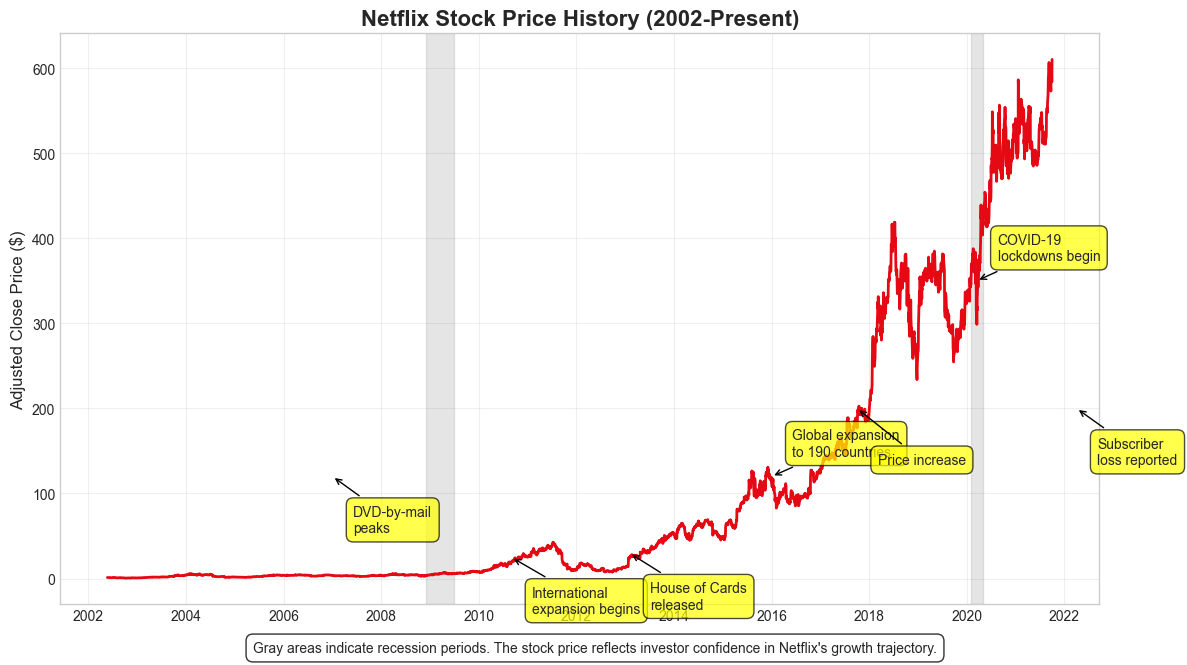

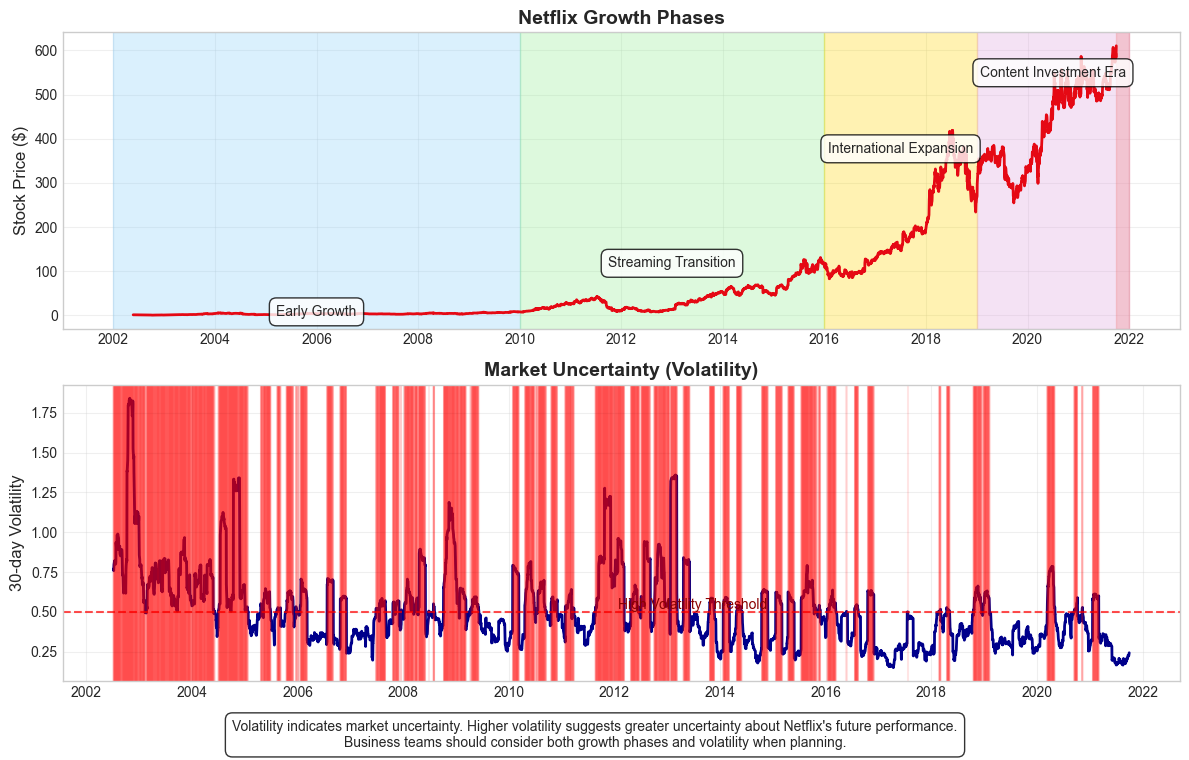

Analysis complete. Visualizations have been created with annotations for a lay audience.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

# Load the data
df = pd.read_csv('C:\\Users\\Aru\\Downloads\\archive\\NFLX.csv')

# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create a formatter for y-axis values (in millions for Volume)
def millions(x, pos):
    return f'{x/1e6:.0f}M'

millionsFormatter = FuncFormatter(millions)

# -------------------------
# 1. HISTORICAL PRICE TRENDS
# -------------------------
# Key visualization for understanding Netflix's growth trajectory
plt.figure(figsize=(12, 7))
plt.plot(df.index, df['Adj Close'], linewidth=2, color='#E50914')  # Netflix red color

# Add recession periods
recession_periods = [
    ('2008-12-01', '2009-06-30'),  # Great Recession
    ('2020-02-01', '2020-04-30')   # COVID-19
]

for start, end in recession_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.2, color='gray')

# Annotate key business events
events = [
    ('2007-01-01', 120, 'DVD-by-mail\npeaks', 'bottom'),
    ('2010-09-01', 25, 'International\nexpansion begins', 'bottom'),
    ('2013-02-01', 30, 'House of Cards\nreleased', 'bottom'),
    ('2016-01-01', 120, 'Global expansion\nto 190 countries', 'top'),
    ('2017-10-01', 200, 'Price increase', 'bottom'),
    ('2020-03-15', 350, 'COVID-19\nlockdowns begin', 'top'),
    ('2022-04-01', 200, 'Subscriber\nloss reported', 'bottom')
]

for date, price, text, position in events:
    plt.annotate(text, 
                xy=(pd.to_datetime(date), price),
                xytext=(15, 15 if position == 'top' else -40),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->', color='black'),
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7))

plt.title('Netflix Stock Price History (2002-Present)', fontsize=16, fontweight='bold')
plt.ylabel('Adjusted Close Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)

# Format x-axis to show years only
years = mdates.YearLocator(2)   # every 2 years
years_fmt = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)

# Add explanatory text for non-technical audience
plt.figtext(0.5, 0.01, 
           "Gray areas indicate recession periods. The stock price reflects investor confidence in Netflix's growth trajectory.", 
           ha='center', fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('netflix_stock_history_annotated.png', dpi=300, bbox_inches='tight')
plt.show()  # Add show to display the plot in notebooks

# -------------------------
# 2. GROWTH PHASES AND VOLATILITY
# -------------------------
# Calculate yearly returns and rolling volatility
df['Returns'] = df['Adj Close'].pct_change()
df['Volatility'] = df['Returns'].rolling(window=30).std() * np.sqrt(252)  # Annualized

plt.figure(figsize=(12, 8))

# Plot 1: Adj Close with growth phases
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df.index, df['Adj Close'], linewidth=2, color='#E50914')

# Define growth phases
growth_phases = [
    ('2002-01-01', '2009-12-31', 'Early Growth', 'lightskyblue'),
    ('2010-01-01', '2015-12-31', 'Streaming Transition', 'lightgreen'),
    ('2016-01-01', '2018-12-31', 'International Expansion', 'gold'),
    ('2019-01-01', '2021-12-31', 'Content Investment Era', 'plum'),
    ('2022-01-01', df.index[-1].strftime('%Y-%m-%d'), 'Mature Competition Phase', 'lightcoral')
]

# Add growth phase shading and labels
for start, end, label, color in growth_phases:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    ax1.axvspan(start_date, end_date, alpha=0.3, color=color)
    
    # Position the label in the middle of each phase
    mid_point = start_date + (end_date - start_date) / 2
    y_pos = df.loc[start_date:end_date, 'Adj Close'].max() * 0.9
    
    ax1.text(mid_point, y_pos, label, 
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

ax1.set_title('Netflix Growth Phases', fontsize=14, fontweight='bold')
ax1.set_ylabel('Stock Price ($)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: Volatility
ax2 = plt.subplot(2, 1, 2)
ax2.plot(df.index, df['Volatility'], linewidth=2, color='darkblue')
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
ax2.text(df.index[int(len(df)/2)], 0.52, 'High Volatility Threshold', color='darkred')

# Highlight high volatility periods
high_vol_periods = df[df['Volatility'] > 0.5].index
for period in high_vol_periods:
    ax2.axvline(x=period, color='red', alpha=0.1)

ax2.set_title('Market Uncertainty (Volatility)', fontsize=14, fontweight='bold')
ax2.set_ylabel('30-day Volatility', fontsize=12)
ax2.grid(True, alpha=0.3)

# Format x-axis to show years only
for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)

# Add explanatory text for non-technical audience
plt.figtext(0.5, 0.01, 
           "Volatility indicates market uncertainty. Higher volatility suggests greater uncertainty about Netflix's future performance.\nBusiness teams should consider both growth phases and volatility when planning.", 
           ha='center', fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig('netflix_growth_phases_volatility.png', dpi=300, bbox_inches='tight')
plt.show()  # Add show to display the plot in notebooks

print("Analysis complete. Visualizations have been created with annotations for a lay audience.")

The goal of this analysis was to analyze the relationship between Netflix Adjusted Closing Prices on the stock market, and volume of sales, over time. 
The ARIMA model (reasons for picking model are stated in code) shows that there is no statistically significant value in terms of the relationship between adjusted closing price and time. This is despite the obvious trends in data that indicate market volitality/events may influence adjusted closing price. 
However, there is a trend that is noticeable in the volume of sales over time. 
There seems to be ways in which NETFLIX adjusts to accrue profit possibly related to different economic times. 
Around 2012 and years prior, NETFLIX seems to have an increased volume of sales coupled with a low stock price. 
This COULD mean that NETFLIX was trying to capture a market geared toward those looking for affordable prices. This was indeed around the time of the Great Recession and NETFLIX's infancy. 
However, after 2012 we can see that NETFLIX's adjusted closing price has increased substantially. This could be due in part to its global expansion, introduction of series such as House of Cards, and COVID lockdown. 
High prices could indicate a desire to capture a global/domestic market that is being increasingly geared toward high earners. 
Questions linger as to how NETFLIX may respond to another market incident such as an AI/Housing bubble/increased growth of households and individuals into developed-country standard middle/upper middle classes. 